### PneumoScan: Chest X-ray Image Classification for Pneumonia Detection

Introduction
- Pneumonia is a critical respiratory infection often diagnosed through chest X-ray imaging. Manual interpretation of these images can be time-consuming and prone to errors. This project aims to develop machine learning models to automate the classification of chest X-rays into normal and pneumonia-affected categories using convolutional neural networks (CNNs).

#### Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

#### Load the Dataset


In [2]:
# Define a function that that preprocesses the data by loading images, resizing them to a uniform size, and converting them to grayscale

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(
                    path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {img}: {str(e)}")
    return np.array(data, dtype=object)

In [3]:
# Load the datasets

train = get_training_data('Data/train')
test = get_training_data('Data/test')
val = get_training_data('Data/val')

# Print the shape of the datasets
print(train.shape)
print(test.shape)
print(val.shape)

Error processing .DS_Store: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing .DS_Store: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

(5865, 2)
(582, 2)
(16, 2)


#### Data Visualization & Preprocessing

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3660\608891133.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette=custom_palette)


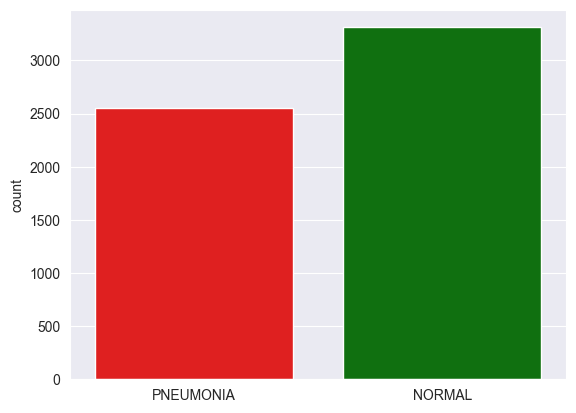

In [4]:
labels = []

for i in train:
    if i[1] == 0:
        labels.append('PNEUMONIA')
    else:
        labels.append('NORMAL')

# Custom palette for the plot
custom_palette = {'PNEUMONIA': 'red', 'NORMAL': 'green'}
sns.set_style('darkgrid')
sns.countplot(x=labels, palette=custom_palette)
plt.show()

- The data is imbalanced. I'll have to apply augmentation to increase the number of training data.

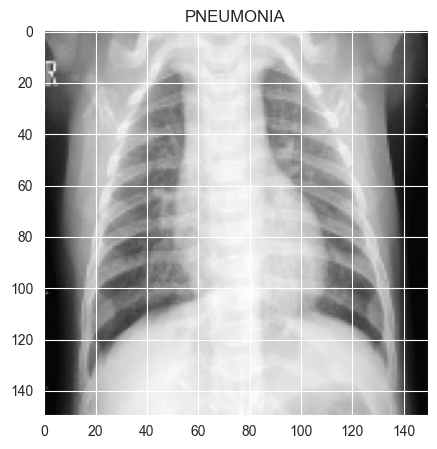

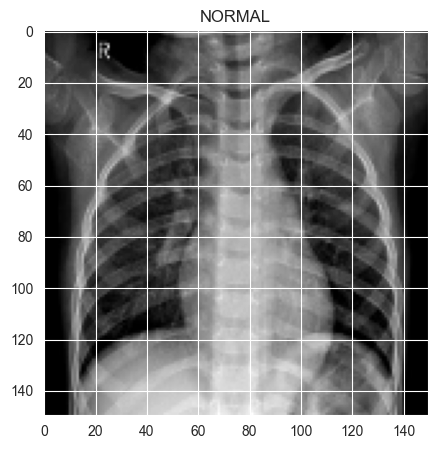

In [5]:
# Preview the images in the dataset

plt.figure(figsize=(5, 5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[0])
# plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[-1])
# plt.axis('off')
plt.show()

- Perform normalization on the data to reduce the effect of illumination defference and increase convergence of the CNN

##### Normalize the data

In [6]:
# Split the data into features and labels
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


In [7]:
# Data normalization

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

In [8]:
# Resize the images to a uniform size
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

#### Data Augmentation

- Data augmentation helps mitigate overfitting problems by increasing the diversity of the existing data.
- This process modifies the training data with subtle transformations to replicate variations while preserving the label.
- Some augmentation techniques implemented here include:
    1. Random rotation of images by 30 degrees.
    2. Random zooming by 10%.
    3. Random vertical shifting of images by 20%.
    4. Random horizontal shifting of images by 20%.


In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=30, # randomly rotate images in the range
    zoom_range=0.1, # Randomly zoom image
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(x_train)

#### Train the models
Train two models:

1. Simple Neural Network 

In [10]:
# Baseline model: Simple Neural Network

from keras.layers import Input

# Specify the batch
batch_size = 32 

simple_model = Sequential([
    Input(shape=(150, 150, 1)),  # Modify the input shape to match the input data
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

simple_model.summary()

# Train the model
simple_model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 22500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,880,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,257 (10.99 MB)

 Trainable params: 2,880,257 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7642 - loss: 1.3609 - val_accuracy: 0.8750 - val_loss: 0.3701
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8930 - loss: 0.2636 - val_accuracy: 0.8125 - val_loss: 0.3294
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8981 - loss: 0.2437 - val_accuracy: 0.9375 - val_loss: 0.2513
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9025 - loss: 0.2363 - val_accuracy: 0.8750 - val_loss: 0.3556
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9048 - loss: 0.2343 - val_accuracy: 0.9375 - val_loss: 0.2328
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8962 - loss: 0.2463 - val_accuracy: 0.8750 - val_loss: 0.2785
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9138 - loss: 0.2110 - val_accuracy: 0.9375 - val_loss: 0.2063
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9238 - loss: 0.1894 - val_acc

In [ ]:
# Save the model
simple_model.save('simple_model.keras')

In [11]:
# Evaluate the model on test data

model_loss, model_accuracy = simple_model.evaluate(x_test, y_test)

print(f"Loss: {model_loss}, Accuracy: {model_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8554 - loss: 0.3681
Loss: 0.29835158586502075, Accuracy: 87.80%


In [18]:
prediction = simple_model.predict(x_test)
print(prediction)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[4.37582225e-01]
 [1.47040009e-01]
 [3.85155439e-01]
 [9.70570207e-01]
 [4.17061057e-03]
 [2.14739866e-03]
 [1.97950285e-03]
 [2.31820988e-04]
 [3.67536023e-02]
 [3.58293593e-01]
 [2.59290487e-02]
 [3.32457051e-02]
 [6.69592619e-02]
 [1.21321306e-02]
 [1.75421998e-01]
 [6.09257698e-01]
 [4.46393877e-01]
 [1.46187186e-01]
 [1.39745940e-02]
 [7.77856708e-02]
 [1.51171610e-01]
 [2.37581924e-01]
 [1.65385574e-01]
 [1.90179422e-02]
 [6.68339655e-02]
 [6.36265397e-01]
 [8.89519811e-01]
 [8.23732242e-02]
 [8.78903031e-01]
 [1.22842519e-02]
 [2.12362036e-01]
 [5.32365367e-02]
 [7.60472059e-01]
 [9.47345853e-01]
 [1.06056118e-02]
 [5.25285080e-02]
 [1.26025781e-01]
 [8.37756961e-04]
 [3.66773340e-03]
 [8.88946280e-02]
 [7.33584445e-03]
 [9.68165457e-01]
 [2.49552280e-02]
 [4.22045263e-03]
 [2.55742040e-03]
 [3.72152716e-01]
 [1.73208187e-03]
 [1.26199459e-03]
 [2.30938499e-03]
 [5.83677053e-01]
 [3.64391766e-02]
 [3.45612280e-02]
 [1.02679501e-03]
 [1.654

2. Optimized CNN Model

In [12]:
Optimized_model = Sequential([
    Input(shape=(150, 150, 1)),  # Modify the input shape to match the input data
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
Optimized_model.compile(optimizer='adam',
                        loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
Optimized_model.summary()

# Train the model with augmentation
Optimized_model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 47s 237ms/step - accuracy: 0.7782 - loss: 0.4210 - val_accuracy: 0.8125 - val_loss: 0.3691
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 63s 341ms/step - accuracy: 0.9358 - loss: 0.1683 - val_accuracy: 0.8125 - val_loss: 0.4471
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 82s 443ms/step - accuracy: 0.9543 - loss: 0.1136 - val_accuracy: 1.0000 - val_loss: 0.1036
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 52s 281ms/step - accuracy: 0.9694 - loss: 0.0754 - val_accuracy: 0.9375 - val_loss: 0.1006
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.9820 - loss: 0.0514 - val_accuracy: 0.8750 - val_loss: 0.1315
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.9859 - loss: 0.0387 - val_accuracy: 0.9375 - val_loss: 0.3031
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.9873 - loss: 0.0346 - val_accuracy: 0.9375 - val_loss: 0.0929
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.9909 - loss: 0

In [13]:
# Save the model
Optimized_model.save('optimized_model.keras')

In [14]:
# Evaluate on test set
optimized_loss, optimized_acc = Optimized_model.evaluate(x_test, y_test)
print(f"Optimized CNN Model - Test Accuracy: {optimized_acc*100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9513 - loss: 0.2173
Optimized CNN Model - Test Accuracy: 94.67%


In [16]:
#Optimized model prediction
Optimized_prediction = Optimized_model.predict(x_test)
print(Optimized_prediction)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
[[6.24585681e-08]
 [7.84720969e-11]
 [3.82097205e-05]
 [8.61299276e-01]
 [1.60333391e-09]
 [1.37169218e-06]
 [2.10459100e-16]
 [6.59692976e-15]
 [9.06378048e-08]
 [1.92643069e-02]
 [1.32403885e-20]
 [1.09878454e-06]
 [2.14621934e-04]
 [9.13739484e-08]
 [9.30778146e-14]
 [1.20546401e-05]
 [2.39265040e-02]
 [2.51355857e-01]
 [6.29759510e-04]
 [1.64213691e-06]
 [2.33546132e-03]
 [1.08676155e-04]
 [6.09092414e-04]
 [2.16882862e-03]
 [3.97360951e-01]
 [1.51106687e-02]
 [2.90573567e-01]
 [6.25788653e-06]
 [8.97815645e-01]
 [4.54149746e-10]
 [1.64918319e-08]
 [9.62505525e-04]
 [4.84424867e-02]
 [9.99219366e-04]
 [1.08057365e-11]
 [7.06681848e-01]
 [7.35615968e-09]
 [4.45459598e-08]
 [4.17266430e-11]
 [6.24193419e-10]
 [2.46666332e-07]
 [9.99716580e-01]
 [4.55990877e-13]
 [1.68994175e-05]
 [1.98622715e-12]
 [1.44584797e-08]
 [5.01257647e-11]
 [1.13810079e-10]
 [8.10168999e-09]
 [8.60916495e-01]
 [9.39748332e-08]
 [4.63147032e-09]
 [2.27574140e-11]
 [5.53

In [26]:
labels = y_test
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [30]:
# Predictions and evaluation
simple_pred_eval = (simple_model.predict(x_test) > 0.5).astype("int32")
optimized_pred_eval = (Optimized_model.predict(x_test) > 0.5).astype("int32")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [33]:
# Classification reports
print("\nSimple Model - Classification Report")
print(classification_report(labels, simple_pred_eval))

print("\nOptimized Model - Classification Report")
print(classification_report(labels, optimized_pred_eval))


Simple Model - Classification Report
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       411
           1       0.72      0.95      0.82       171

    accuracy                           0.88       582
   macro avg       0.85      0.90      0.86       582
weighted avg       0.90      0.88      0.88       582


Optimized Model - Classification Report
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       411
           1       0.90      0.92      0.91       171

    accuracy                           0.95       582
   macro avg       0.93      0.94      0.94       582
weighted avg       0.95      0.95      0.95       582



In [35]:
# Confusion Matrix
print("Simple Model - Confusion Matrix")
print(confusion_matrix(labels, simple_pred_eval))

print("Optimized Model - Confusion Matrix")
print(confusion_matrix(labels, optimized_pred_eval))

Simple Model - Confusion Matrix
[[348  63]
 [  8 163]]
Optimized Model - Confusion Matrix
[[393  18]
 [ 13 158]]
